In [1]:
import math
import datetime as dt
import pickle

import pandas as pd
import numpy as np
import numba
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
from importlib import reload

## Test generator.py

In [2]:
import generator

In [3]:
reload(generator)

<module 'generator' from 'C:\\Users\\Sharp.Ra\\PyProjects\\FinalMDS\\generator.py'>

In [7]:
# LOAD spread PMF (probability mass function) as numpy.ndarray
spreads = np.load('spreads.npz')['arr_0']
for i, s in enumerate(spreads):
    print(f"Spread {i+1} tick - probability {s*100:0.2f}%")

Spread 1 tick - probability 16.91%
Spread 2 tick - probability 31.10%
Spread 3 tick - probability 35.04%
Spread 4 tick - probability 13.40%
Spread 5 tick - probability 2.89%
Spread 6 tick - probability 0.66%


In [8]:
# create generator object
m = generator.Market(mu=0, sigma=0.14, ticksize=0.0025, spread_pmf=spreads, basis='hour')

In [9]:
# LOAD PMF for x50 volumes
# See Market order volumes.ipynb 
m.init_x0_model('PMFx50.npz')

In [10]:
# Load KDE model for xx volumes
# See Market order volumes.ipynb 
m.init_xx_model('kde_model.pickle')

In [13]:
start_time = dt.datetime(2020, 1, 1, 10, 0)
end_time = dt.datetime(2020, 1, 1, 18, 0)

In [14]:
%%time
# generate times
z2, w2 = m.generate_order_times(2000, start_time, end_time)

Wall time: 1.37 s


In [16]:
# generate bid/ask
b2, a2 = m.generate_bid_ask_prices(w2, 75.)

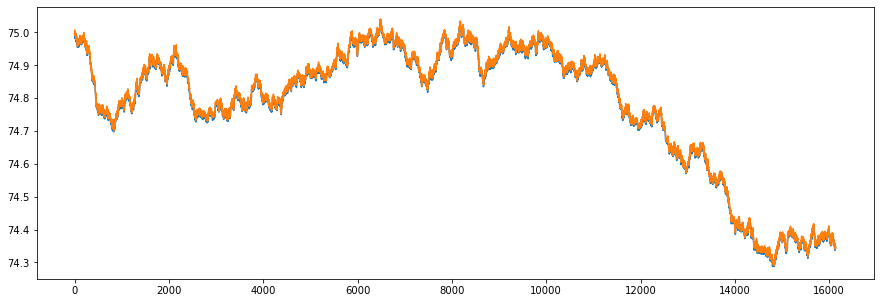

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(b2)
plt.plot(a2)

<AxesSubplot:ylabel='Count'>

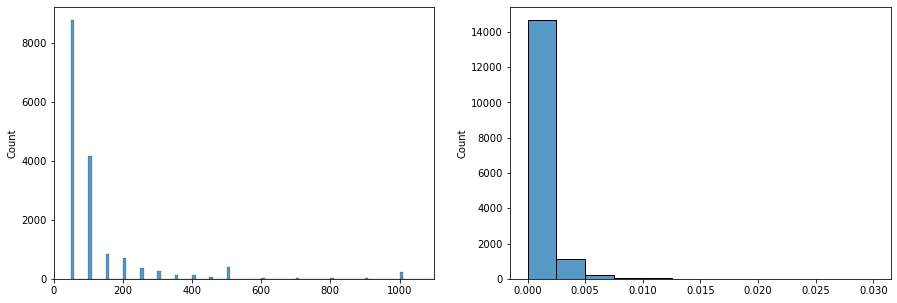

In [28]:
# generate x50/x500 volumes/impacts
mx = m.generate_market_orders_x0(z2.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(mx[:, 0], binwidth=10, ax=ax[0], label='volumes')
ax[0].set_xlim([0, 1100])
sns.histplot(mx[:, 1], binwidth=0.0025, ax=ax[1], label='impact')

<AxesSubplot:ylabel='Count'>

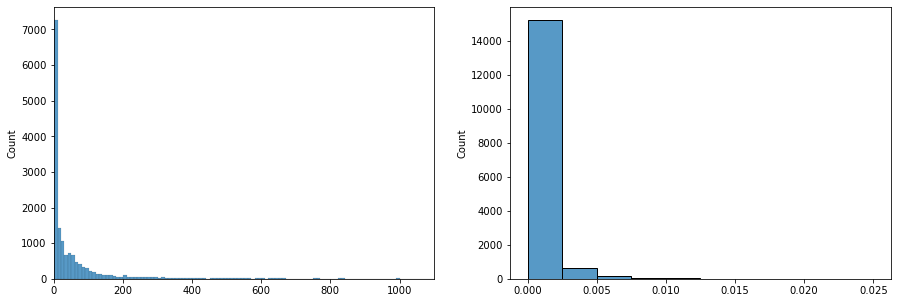

In [27]:
# generate regular volumes/impacts
mxx = m.generate_market_orders_xx(z2.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(mxx[:, 0], binwidth=10, ax=ax[0], label='volumes')
ax[0].set_xlim([0, 1100])
sns.histplot(mxx[:, 1], binwidth=0.0025, ax=ax[1], label='impact')

In [21]:
# Get all together: generate order book
df_mb = m.order_book(2200, 75., start_time, end_time, 0.5, 0.36)

In [22]:
df_mb[:5]

,Time,Side,Volume,Impact,BID,ASK
0,2020-01-01 10:00:07.233759,1,50.0,0.0,75.0025,75.0100
1,2020-01-01 10:00:11.322366,-1,50.0,0.0,74.9950,75.0025
2,2020-01-01 10:00:12.876688,-1,100.0,0.0,74.9925,74.9975
3,2020-01-01 10:00:13.424058,1,3.0,0.0,74.9875,74.9950
4,2020-01-01 10:00:14.724521,-1,100.0,0.0,74.9900,74.9975


<AxesSubplot:xlabel='Impact', ylabel='Count'>

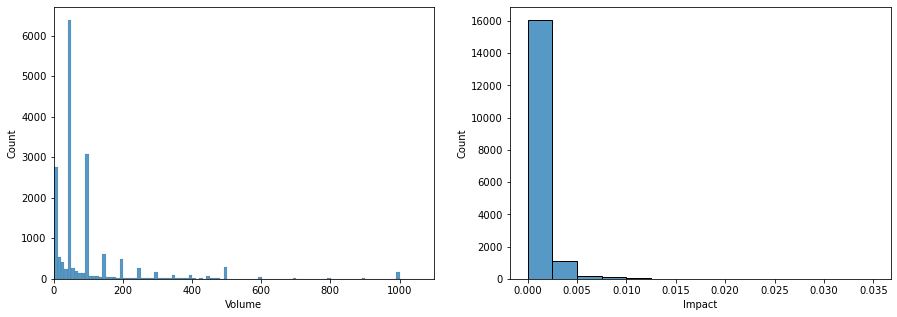

In [26]:
# Final volume and impact distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_mb['Volume'], binwidth=10, ax=ax[0], label='volumes')
ax[0].set_xlim([0, 1100])
sns.histplot(df_mb['Impact'], binwidth=0.0025, ax=ax[1], label='impact')

## Generate a lot of data for further quality analysis

In [38]:
xstart = start_time
xend = end_time
df_res = pd.DataFrame(columns=df_mb.columns)
xprice = 75
for _ in tqdm(range(200)):    
    df_mb = m.order_book(2200, xprice, start_time, end_time, 0.5, 0.36)
    xstart = xstart + dt.timedelta(days=1)
    xend = xend + dt.timedelta(days=1)
    xprice = df_mb['BID'].iloc[-1]
    df_res = df_res.append(df_mb, ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
df_res[:5]

,Time,Side,Volume,Impact,BID,ASK
0,2020-01-01 10:00:03.463442,-1,300.0,0.0,75.0000,75.0025
1,2020-01-01 10:00:04.830754,-1,100.0,0.0,75.0000,75.0025
2,2020-01-01 10:00:05.400756,-1,50.0,0.0,75.0025,75.0125
3,2020-01-01 10:00:08.166024,1,50.0,0.0,75.0000,75.0075
4,2020-01-01 10:00:08.171940,1,50.0,0.0,75.0000,75.0025


In [40]:
df_res.shape

(3521160, 6)

In [ ]:
# export generated order book
df_res.to_feather('mo_gen_USDRUB.feather')